<a href="https://colab.research.google.com/github/moran500/predict_future_price/blob/master/predict_future_sales_clear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install missing packages to colab
!pip3 install catboost
# print(sns.__version__)
!pip3 install --upgrade somepackage seaborn==0.9.0
# print(sns.__version__)

    100% |████████████████████████████████| 60.6MB 659kB/s 
Requirement already up-to-date: seaborn==0.9.0 in /usr/local/lib/python3.6/dist-packages (0.9.0)
  Stored in directory: /root/.cache/pip/wheels/8f/99/38/629e5a3389c43538eb1c242508e84750aefbf4894a65ef5b1f
Successfully built somepackage


In [0]:
# install kaggle connection
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

!pip install -q kaggle
!pip install -q kaggle-cli

# !kaggle datasets list

# !kaggle competitions list

In [0]:
# download dataset from kaggle to cloud
!kaggle competitions download -c competitive-data-science-predict-future-sales
!ls

!gunzip sales_train.csv.gz
!gunzip sample_submission.csv.gz
!gunzip test.csv.gz

In [0]:
import pandas as pd
import numpy as np
import pickle as p
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import DMatrix
from xgboost import cv
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import os
import sys
import kaggle

pd.set_option('float_format', '{:.3f}'.format)

In [0]:
# data, items and item_cattegories import
data = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
items_cat = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
# load test data
test_data = pd.read_csv("test.csv")

In [0]:
# LIKE KAGGLE
# join data with items and then with items_cat and with city and with address and with shop name
# also this works where you can use left join merge(item[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
data = pd.merge(data, items, how="inner", on=["item_id"])
data = pd.merge(data, items_cat, how="inner", on=["item_category_id"])
data = pd.merge(data, shops, how="inner", on=["shop_id"])

data.head()

In [0]:
# EDA
# how many observations do I have
data.count()
# how many features do I have
data.columns
len(data.columns)
# what are the data types of features, categorical(nominal or ordinal) or numerical
data.info()
# do the columns make sense?
# YES
# do the values make sense in the columns?
# YES
# What is the scale of each numerical feature?
data.describe()
# do I have some NULL values? If yes, are they problematic?
data.isnull().sum()
# do I have some NA values? If yes, are they problematic?
data.isna().sum()
# do I have some duplicates?
# important, the duplicated is showing just N-1 row, so the first which is original is not shown in data[data.duplicated() == True]
data.duplicated().sum()
data[data.duplicated() == True]
# what are the statistics abdout each column?
data.describe()

In [0]:
sns.catplot(y="shop_name", data=data, kind="count", height=20, aspect=.8, order=shops.sort_values("shop_name")["shop_name"])

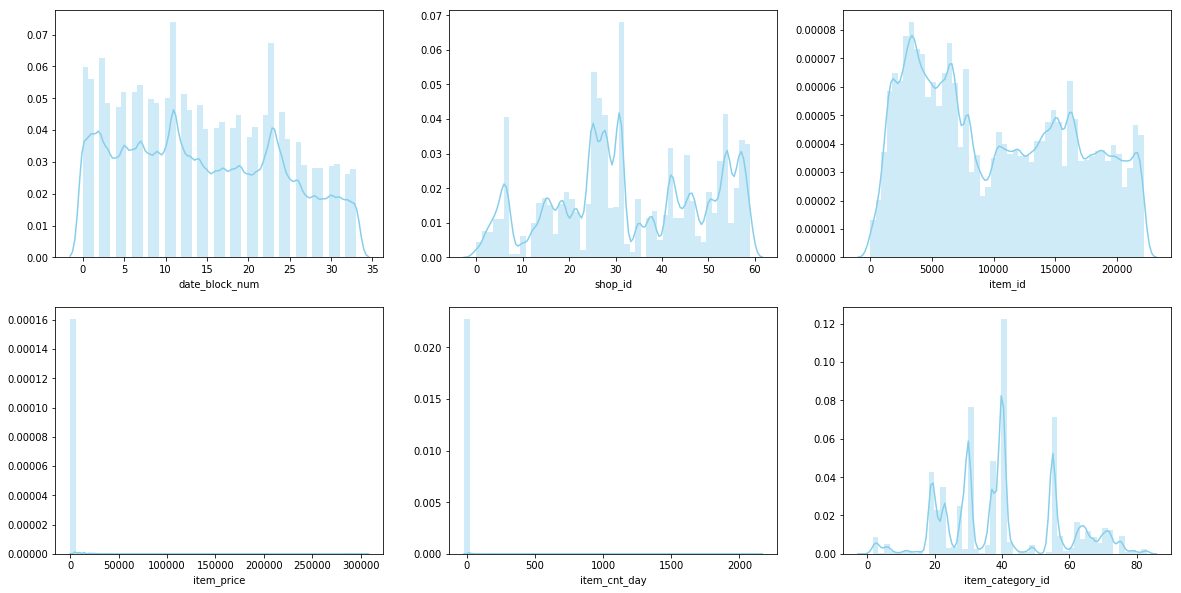

In [0]:
# EDA
# numerical features
num_columns = ["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id"]
f, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False)
for ax, feature in zip(axes.flat, num_columns):
    sns.distplot(data[feature] , color="skyblue", ax=ax)

In [0]:
test = data.groupby(["item_category_id", "item_category_name"])["item_price"].count()
test[test > 100000]

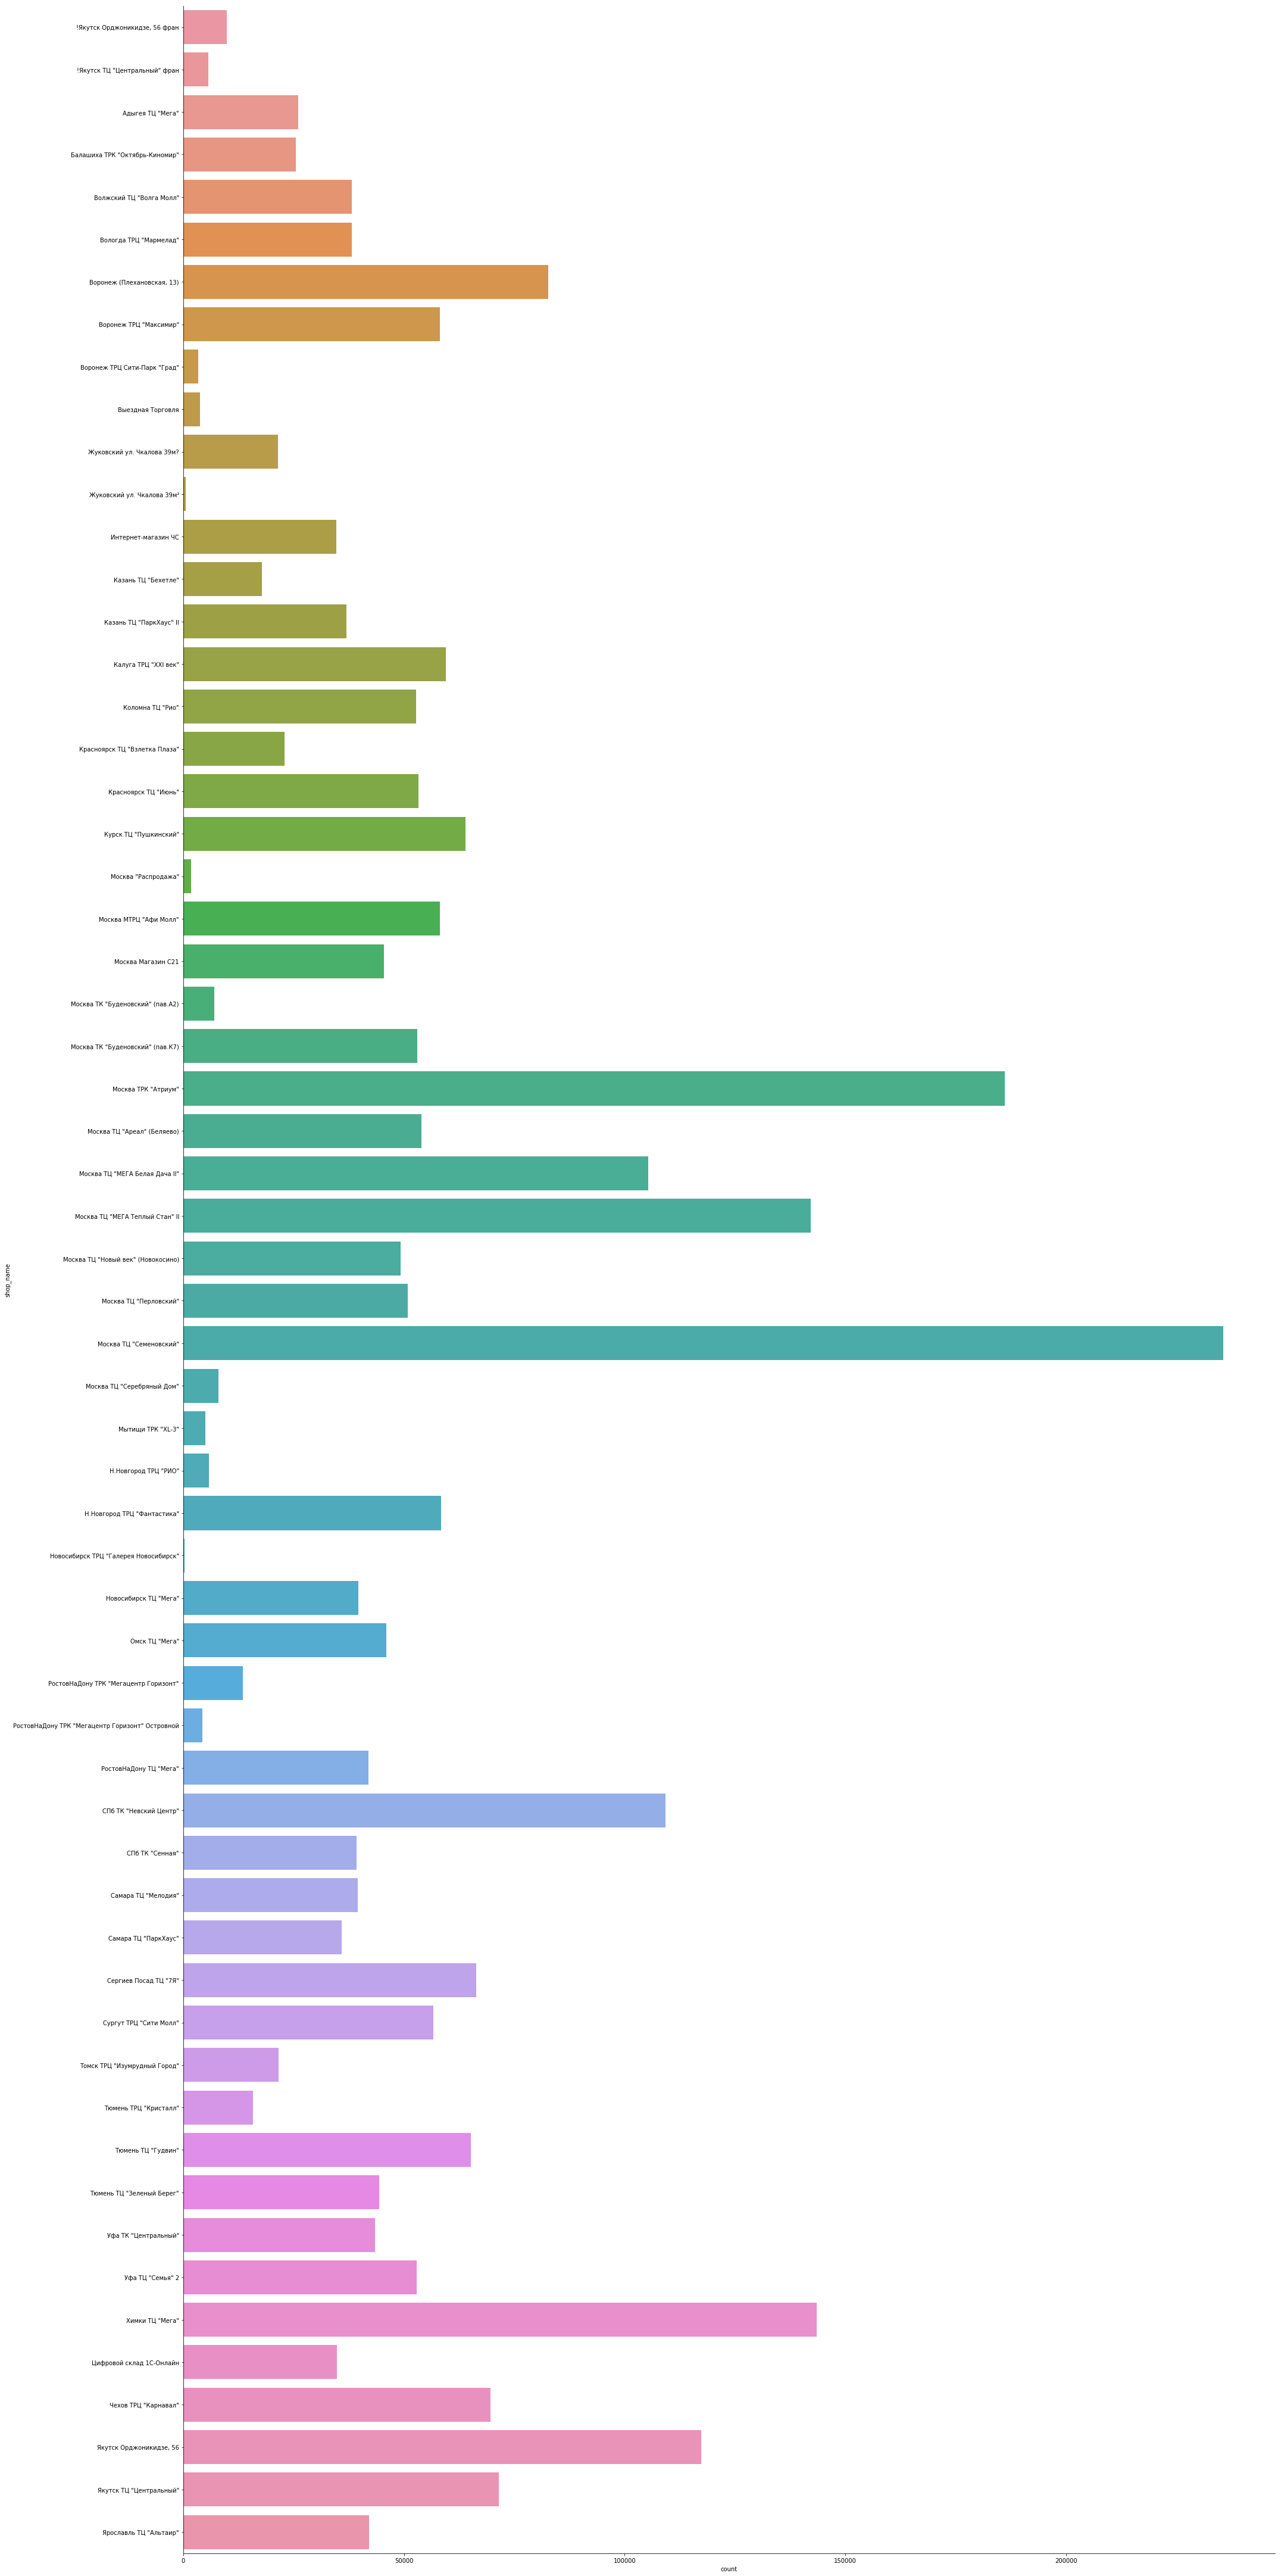

In [8]:
# EDA
# Categorical distributions

# cat_columns = ["shop_name", "item_category_name", "item_name"]
# f, axes = plt.subplots(2, 1, figsize=(20, 40), sharex=False)
# for ax, feature in zip(axes.flat, cat_columns):
#     sns.catplot(y=feature, data=data, kind="count", ax=ax, order=np.sort(data[feature]))
    
# check the structurals erros in categorical data
# data["shop_name"].unique()
sns.catplot(y="shop_name", data=data, kind="count", height=len(shops), aspect=.5, order=shops.sort_values("shop_name")["shop_name"])
# sns.catplot(y="item_name", data=data, kind="count", height=len(items)/50, aspect=.8, order=items.sort_values("item_name")["item_name"])
# sns.catplot(y="item_category_name", data=data, kind="count", height=100, aspect=.8, order=items_cat.sort_values("item_category_name")["item_category_name"])

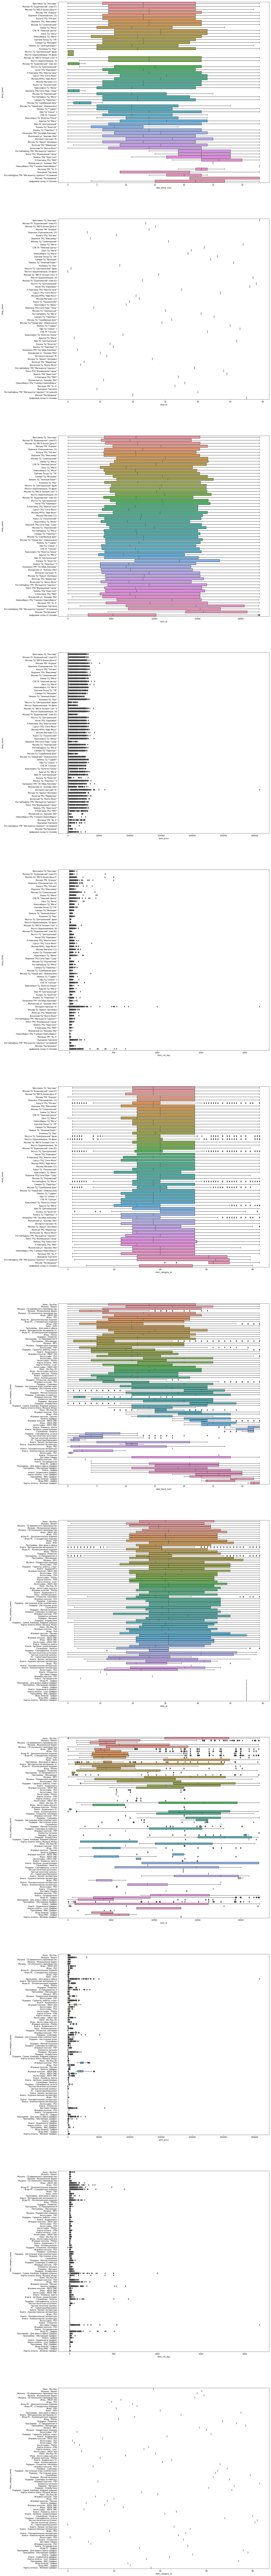

In [0]:
# EDA
# Segmentation ratio
# Be careful bacause on X axis you have always only categorical features
cat_columns = ["shop_name", "item_category_name"]
num_columns = ["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id"]
f, axes = plt.subplots(12, 1, figsize=(20, 250), sharex=False)
k=0
for i in  range(0, len(cat_columns)):
    for j in  range(0, len(num_columns)):
        sns.boxplot(x=num_columns[j], y=cat_columns[i], data=data, ax=axes[k], orient="h")
        k+=1

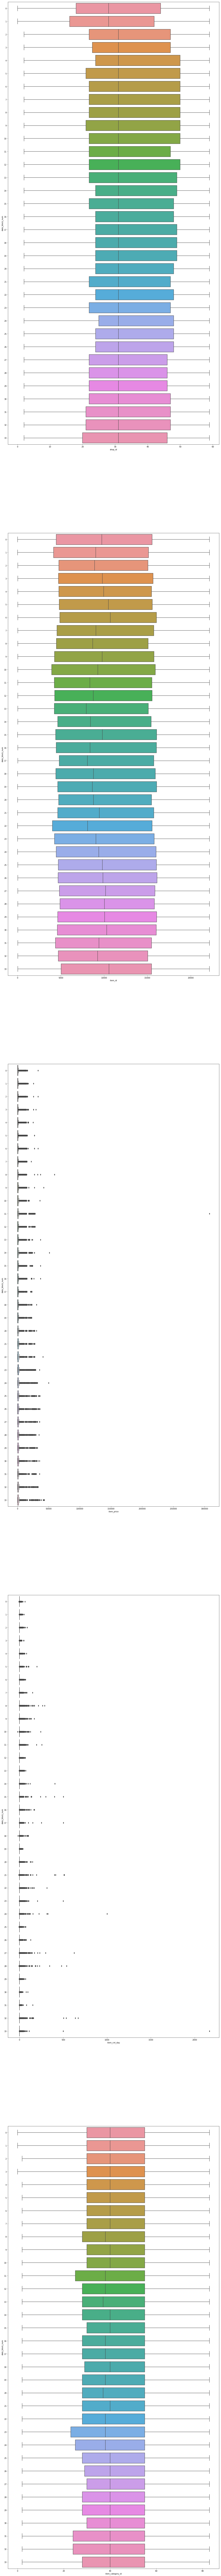

In [12]:
# EDA
# Segmentation ratio
# Be careful bacause on X axis you have always only categorical features
cat_columns = ["date_block_num"]
num_columns = ["shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id"]
f, axes = plt.subplots(5, 1, figsize=(20, 250), sharex=False)
k=0
for i in  range(0, len(cat_columns)):
    for j in  range(0, len(num_columns)):
        sns.boxplot(x=num_columns[j], y=cat_columns[i], data=data, ax=axes[k], orient="h")
        k+=1

# notes
# all shops are presented in all time periods
# all categories are presented in all time periods
# all items are presented in all time periods

In [0]:
# EDA
# collerations
corr = data.corr()
sns.heatmap(corr, annot=True)
# Basic correlogram
sns.pairplot(data)

In [0]:
# general
# I have 6 rows which are duplicated
# in general features are not collerating between each other

# date_block_num
# date_block_num max is 33 but 50% is 14 and not 16,5 that means that the distribution is not equal, but I have to prove it
# in december is big spike with sales, so we have seasonality => adding the column month will capture this aspect => maybe some feature with the total sales over month will also help
# in general the sales have dicreasing trend over the years => adding the column year will capture this aspect => maybe some featyre with the total sales over the entire year would help

# shop_id
# shop_id colum is categorical and it looks reasanable
# just some shops are seling the most items => adding feature with the adress or city or where is the shop located could help

# item_id
# item_id column is categorical and it looks reasanable
# some items are seling better then other => feature with the category for the high demanded products will help

# item_price
# item_price ma min -1 a to sa mi nepaci a tiez ma maximalku ktora je 177 sigma a dokonca std je vacsie ako mean cize tu musime nieco spravit s outliers
# I have some issue with item_price it looks like that I have some outliers where the price is super high but the density of this price is super low => removing of the outliers will help
# item_price have brutal outlier, but be carefull if you will remove it then it check also the rest which looks ok now => remove outliers

# item_cnt_day
# item_cnt_day zase strasne velka max hodnota a tiez minimum je -22 treba zistit preco je to zaporne a kolko a nieco s tym spravit
# I have some issue with item_cnt_day it looks like that I have some outliers where the number of item_cnt_day is super high but the density of this amount is super low => removing of the outliers will help
# item_cnt_day have brutat outliers in some shops, check what those are => potencialy remove those outliers

# item_category_id
# item_category_id categorical feature treba skontrolovat ci sa nahodou neopakuju spolu s menom
# there are just few item categories which are covering the main amount out sold items => try to check the similarity if the category and group it together will probably help

# shop_name
# I have issue in shop_name there are 2 shop_ids with the same name
# I have some shops from which I have sales information only from few months and 2 shops have just data from 1 month, what is strange that these two shops cover all possible items => does it make sense to keep then? PROVE THIS!!!!
# I have 9 shops which where the main category is sub set of categories and they dont sell equaly everythig => but what to do with this information
# there are shops which are selling only one category of products, maybe some special shops

# item_name
# too large for exploring

# category_name
# I have issue in category_name there are 2 item_cat_ids with the same name just the diferent is in the ()
# some categories are sold only in the begining and then rearly and rearly and some are sold only at the end of time, this could be that we have old items which are selling less and less and then we have some new items comming to the shop => should I remove them which are not sold anymore?
# is it possible that one item can be in 2 different categories?


In [129]:
# test if we have shops which are presented only in few months
test_grouped = data.groupby(["shop_id", "date_block_num"])["item_id"].sum()

test = pd.DataFrame(test_grouped)
test.reset_index(level=["shop_id", "date_block_num"], inplace=True)

test_g2 = test.groupby("shop_id")["date_block_num"].count()

test_g2_df = pd.DataFrame(test_g2)
test_g2_df.reset_index(level=["shop_id"], inplace=True)

test_g2_df.sort_values("date_block_num")

,shop_id,date_block_num
11,11,1
36,36,1
0,0,2
20,20,2
1,1,2
8,8,4
23,23,4
9,9,4
32,32,7
33,33,9


In [0]:
# LIKE KAGGLE
# Data leakages
# is this elimination of the data just for those which we have in data which we need to predict?

test_shop_ids = test_data['shop_id'].unique()
test_item_ids = test_data['item_id'].unique()
# Only shops that exist in test set.
data = data[data['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
data = data[data['item_id'].isin(test_item_ids)]

print('Data set size before leaking:', data.shape[0])

In [0]:
# LIKE KAGGLE
# Data preprocessing
# Select only useful features.
data_agg_selected = data[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

# agregation and creation of agreggated dataset
data_agg = data_agg_selected.groupby([ "shop_id", "item_id", "date_block_num", "item_category_id"])["item_cnt_day", "item_price"].sum()
# change the index in DataFrame to the column
data_agg = data_agg.reset_index(level=[ "shop_id", "item_id", "date_block_num", "item_category_id"])

In [0]:
# LIKE KAGGLE
# !!!!!!!!!!!!!!!!!!!!KEY STEP!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Data preprocessing
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = data_agg['shop_id'].unique()
item_ids = data_agg['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [0]:
# LIKE KAGGLE
# !!!!!!!!!!!!!!!!!!!!KEY STEP!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Removing outliers
data_agg = data_agg.query('item_cnt_day >= 0 and item_cnt_day <= 20 and item_price < 400000')
# data = data[data.item_cnt_day <= 500]
# data = data[data.item_price <= 50000]
data_agg = data_agg[["shop_id","item_id", "item_category_id", "year", "month", "item_cnt_day"]]

In [0]:
# FEATURE ENGINEERING
# Nastudovat si a zatial sa hrame len s tymi co mame

In [0]:
# LIKE KAGGLE
# Feature Engineering
# Extract time based features.
data_agg['year'] = data_agg['date_block_num'].apply(lambda x: ((x//12) + 2013))
data_agg['month'] = data_agg['date_block_num'].apply(lambda x: (x % 12))

In [0]:
# I should implement some feature selction process
X_data = data_agg.iloc[:, data_agg.columns != "item_cnt_day"]
y_data = data_agg.iloc[:, data_agg.columns == "item_cnt_day"]

In [0]:
# data split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=7)

In [0]:
# Feature selection 
# NASTUDOVAT SI!!!!!!!!!!!!!!!!!!!!!Zatial ideme so vsetkymi

In [0]:
# Hyperparameters tuning on the data subset together with cross-validation before the final training of the model on the all train data
# Set the parameters by cross-validation
tuned_parameters = [{
#                   step1  
                    "max_depth": range(3,10,2),
                    "min_child_weight": range(1,6,2)
#                   step2
#                     "gamma":[i/10.0 for i in range(0,5)]
#                   step3
#                     "subsample":[i/10.0 for i in range(6,10)],
#                     "colsample_bytree":[i/10.0 for i in range(6,10)]
}]


grid = GridSearchCV(XGBRegressor(n_estimators=5), tuned_parameters, cv=2, scoring="neg_mean_squared_error", verbose=True)
# grid.fit(X_train, y_train, early_stopping_rounds=3)
grid.fit(X_data, y_data, verbose=True)

print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [0]:
# XGBoost model 1
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["rmse"]

model = XGBRegressor(max_depth=8, n_estimators=500, min_child_weight=1000, colsample_bytree=0.7, subsample=0.7, eta=0.3, seed=0)

model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=10, early_stopping_rounds=10)

print(model)
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model, ax=ax)
plt.show()

p.dump(model, open("xgboost_model4.pickle", "wb"))
 
t = np.linspace(0, 2*math.pi, len(model.evals_result().get("validation_0").get("rmse")))
plt.plot(t, model.evals_result().get("validation_0").get("rmse"), "b", label="train")
plt.plot(t, model.evals_result().get("validation_1").get("rmse"), "g", label="test")
plt.legend()
plt.ylabel('rmse')
plt.show()

In [0]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels.values))
    max_val = min(min(predictions), min(labels.values))
    # Create dataframe with predicitons and labels.
#     performance_df = pd.DataFrame({"Label":labels})
    performance_df = labels
    performance_df.columns = ["Label"]
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
# Let's see how catboost performed with this "prediction x label" plot.
# The closer the points are to the middle dashed line the better are the predictions.
# BE CARFUL THIS IS ADDING TO THE Y_TEST DATAFRAME NEW COLUMN LABEL
xgboost_val_pred = model.predict(X_test)
model_performance_sc_plot(xgboost_val_pred, y_test, 'Validation')

In [0]:
# add additional information to predincting data
test_data = pd.merge(test_data, items, how="inner", on=["item_id"])
test_data = pd.merge(test_data, items_cat, how="inner", on=["item_category_id"])
test_data = pd.merge(test_data, shops, how="inner", on=["shop_id"])
test_data['year'] = 2015
test_data['month'] = 11
test_data.head()

In [0]:
test_data = test_data[["shop_id","item_id", "item_category_id", "year", "month"]]

In [0]:
#create the prediction of testing data
predictions = model.predict(test_data)

In [0]:
# create the submission for kaggle
submission = pd.DataFrame({"item_cnt_month":predictions})
# create the incremental number in first column
submission = submission.reset_index()
submission.columns = ["ID", "item_cnt_month"]
# export to csv
submission.to_csv("submission.csv", index=False)